In [34]:
%matplotlib inline
%pylab inline

from functools import partial

import menpo.io as mio
from menpo.feature import imgfeature, fast_dsift

from menpo.landmark import labeller, ibug_face_68_trimesh
from menpo.visualize import visualize_images, print_dynamic, plot_graph
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

from menpofit.result import compute_normalise_point_to_point_error, compute_cumulative_error
from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    SSDForwardNewtonSimultaneous,
    SSDForwardNewtonAlternated,
    SSDInverseNewtonSimultaneous,
    SSDInverseNewtonAlternated,
    SSDAsymmetricNewtonSimultaneous,
    SSDAsymmetricNewtonAlternated,
    SSDBidirectionalNewtonSimultaneousCombined,
    SSDBidirectionalNewtonSimultaneous,
    SSDBidirectionalNewtonAlternated,
    SSDBidirectionalNewtonAlternatedCombined)
from menpofit.visualize import visualize_fitting_result, plot_ced, print_progress

Populating the interactive namespace from numpy and matplotlib


In [2]:
@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)

In [38]:
image_folder = '/vol/atlas/databases/'
model_folder = '/data/papers/alabort_arxiv2015_aam/experiments/'
result_name = '/data/papers/alabort_arxiv2015_aam/experiments/algorithms/ssd_n/'

## Load AAM

In [4]:
aam = mio.import_pickle(model_folder + 'aam.pkl.gz')

## Load test data

In [5]:
test_images = []
for i in mio.import_images(image_folder + 'lfpw/testset/', 
                           verbose=True, max_images=None):    
    i = i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_68_trimesh)
    if i.n_channels == 3:
        test_images.append(i)

Importing assets: [==========] 100% (224/224) - done.                           


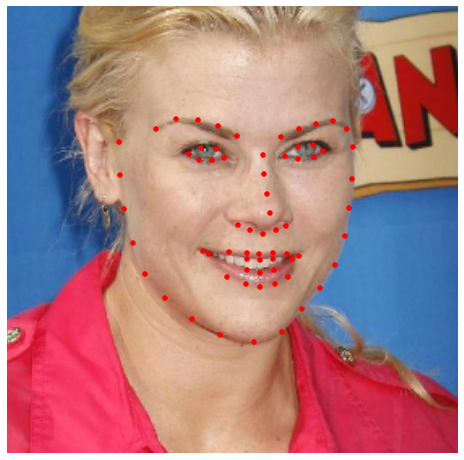

In [6]:
visualize_images(test_images)

## Fit Active Appearance Models

In [15]:
n_shape = [3, 12]
n_appearance = 0.75
max_iters = [24, 16]
scale = 0.5
noise_percentage = 0.04

repeat = 1

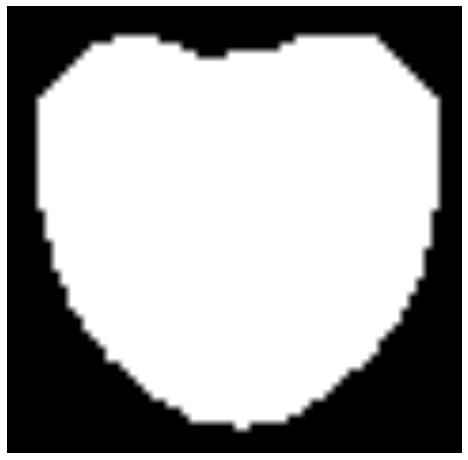

In [16]:
sampling_step_1, sampling_mask_1 = holistic_sampling_from_scale(aam.appearance_models[0].mean(), 
                                                                scale=np.minimum(2 * scale, 1))

sampling_mask_1.view()

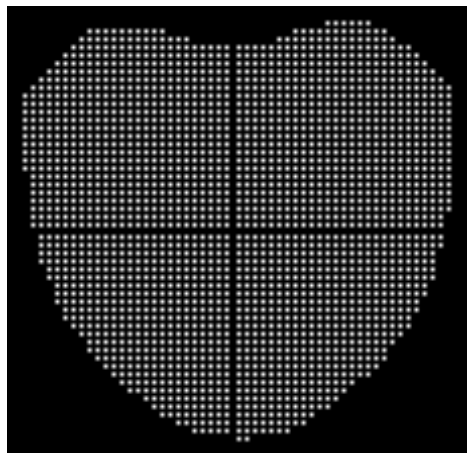

In [17]:
sampling_step_2, sampling_mask_2 = holistic_sampling_from_scale(aam.appearance_models[1].mean(), scale=scale)

sampling_mask_2.view()

In [20]:
sampling_step = [sampling_step_1, sampling_step_2]

#### AAM Fitter

In [21]:
algorithms = [SSDForwardNewtonSimultaneous,
              SSDForwardNewtonAlternated,
              SSDInverseNewtonSimultaneous,
              SSDInverseNewtonAlternated,
              SSDAsymmetricNewtonSimultaneous,
              SSDAsymmetricNewtonAlternated,
              SSDBidirectionalNewtonSimultaneous,
              SSDBidirectionalNewtonAlternated]

fitters = []
for algorithm in algorithms:

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(algorithm),
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters.append(fitter)

In [22]:
am_0 = fitter.aam.appearance_models[0]
am_1 = fitter.aam.appearance_models[1]

print '1st scale -> \tvariance:', am_0.variance_ratio(), '\tcomponents:', am_0.n_active_components
print '2nd scale -> \tvariance:', am_1.variance_ratio(), '\tcomponents:', am_1.n_active_components

1st scale -> 	variance: 0.750527448226 	components: 225
2nd scale -> 	variance: 0.750279464542 	components: 280


In [23]:
n_fitters = len(fitters)
legend_entries = ['Initialization', 
                  'SSD_For_N_Sch',
                  'SSD_For_N_Alt',
                  'SSD_Inv_N_Sch',
                  'SSD_Inv_N_Alt',
                  'SSD_Asy_N_Sch',
                  'SSD_Asy_N_Alt',
                  'SSD_Bid_N_Sch', 
                  'SSD_Bid_N_Alt']

#### Fitting loop

In [24]:
fitters_results = []
for j, image in enumerate(repeat * test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters[0].noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

## Results

In [27]:
serializable_fitters_results =[]

for fr in print_progress(fitters_results):
    serializable_fitters_results.append(fr.as_serializableresult())
    
mio.export_pickle(serializable_fitters_results, result_name + 'ssd_n.pkl.gz')

[====================] 100% (1792/1792) - done.                                 


In [28]:
# fitters_results = mio.import_pickle(result_name + 'ssd_n.pkl.gz')

# n_fitters = 8
# legend_entries = ['Initialization', 
#                   'SSD_For_N_Sch',
#                   'SSD_For_N_Alt',
#                   'SSD_Inv_N_Sch',
#                   'SSD_Inv_N_Alt',
#                   'SSD_Asy_N_Sch',
#                   'SSD_Asy_N_Alt',
#                   'SSD_Bid_N_Sch', 
#                   'SSD_Bid_N_Alt']
# max_iters = [24, 16]
# noise_percentage = 0.04

Produce CED graph:

In [29]:
errors = [[]]
for fr in fitters_results[::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)

In [35]:
x_axis =  np.arange(0, 0.055, 0.005)

cumulative_errors = []
for err in errors:
    cumulative_errors.append(compute_cumulative_error(err, x_axis))

IndexError: list index out of range

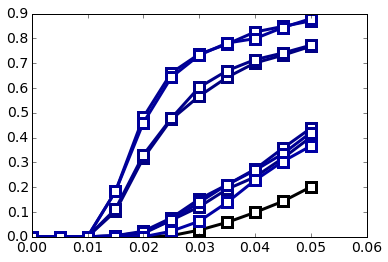

In [46]:
colours = ['black'] + sample_colours_from_colourmap(len(errors)-1, 'jet')

fig = plt.figure()
plt.hold(True)


for i in range(len(errors)):
    plt.plot(x_axis,
             cumulative_errors[i],
             color=colours[i],
             linewidth=3,
             marker='s',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=3)
    
plt.xlabel('Normalized point-to-point error')
plt.ylabel('Proportion of images')
plt.xlim((x_axis[0], x_axis[-1]))
plt.ylim((0, 1))
plt.legend(legend_entries, loc=2)
plt.grid(True)

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(1.75 * fig.get_size_inches())

plt.savefig(result_name + 'ced_ssd_n_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

Produce fitting statistics:

In [37]:
for j, e in enumerate(errors):
    print legend_entries[j], '\tmean:', np.mean(e), '\tstd:', np.std(e), '\tmedian:', np.median(e)

Initialization 	mean: 0.0734712336648 	std: 0.0263931825425 	median: 0.0718227115005
SSD_For_N_Sch 	mean: 0.037577540588 	std: 0.0283970037741 	median: 0.0264428905911
SSD_For_N_Alt 	mean: 0.0606008405203 	std: 0.0275151036698 	median: 0.0567450103214
SSD_Inv_N_Sch 	mean: 0.0365500717821 	std: 0.0272152182366 	median: 0.025419079042
SSD_Inv_N_Alt 	mean: 0.0587640884327 	std: 0.0271562490264 	median: 0.0543091704747
SSD_Asy_N_Sch 	mean: 0.0293946899597 	std: 0.0240910506024 	median: 0.0203026843482
SSD_Asy_N_Alt 	mean: 0.0592576896154 	std: 0.0272253085992 	median: 0.0548975984422
SSD_Bid_N_Sch 	mean: 0.0299720154075 	std: 0.0243381947385 	median: 0.0204064093748
SSD_Bid_N_Alt 	mean: 0.0621125791333 	std: 0.0263457959913 	median: 0.0578600581816


Produce mean and median error convergence graphs:

In [39]:
mean_errors = []
std_errors = []
median_errors = []
for j in range(n_fitters):
    errors = []
    for fr in fitters_results[j::n_fitters]:
        errs = []
        for shape in fr.shapes:
            err = compute_normalise_point_to_point_error(shape.points[17:, :], 
                                                         fr.gt_shape.points[17:, :],
                                                         norm_shape=fr.gt_shape.points)            
            errs.append(err)
        while len(errs) < np.sum(max_iters) + aam.n_scales:
            errs.append(errs[-1])
        errors.append(errs)
    mean_errors.append(np.mean(errors, axis=0))
    std_errors.append(np.std(errors, axis=0))
    median_errors.append(np.median(errors, axis=0))

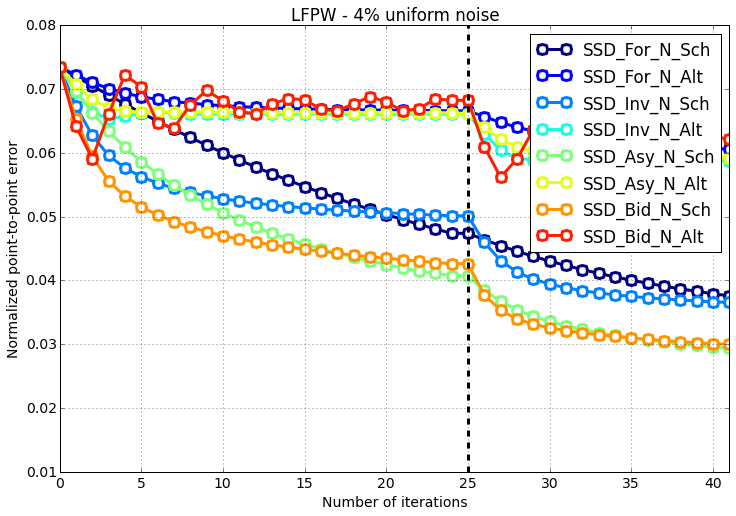

In [40]:
colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             mean_errors[i],
             color=colours[i],
             linewidth=3,
             marker='o',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.01, 0.08))
plt.grid(True)
plt.legend(legend_entries[1:])

xs = (max_iters[0] + 1 , max_iters[0] + 1)
ys = (0.01, 0.08)
plt.plot(xs, ys, 'k--', lw=3)

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

fig.set_size_inches(1.75 * fig.get_size_inches())

plt.savefig(result_name + 'mean_error_vs_iters_ssd_n_{}.png'.format(int(100*noise_percentage)),  
            format='png', dpi=300, bbox_inches='tight')

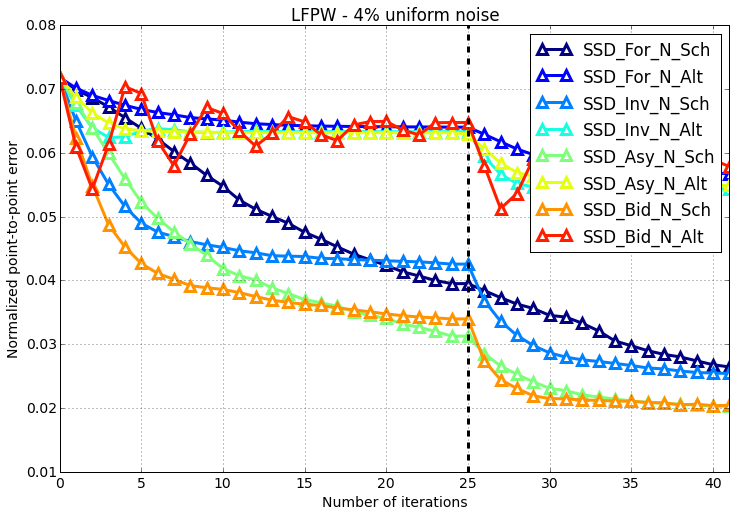

In [41]:
colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             median_errors[i],
             color=colours[i],
             linewidth=3,
             marker='^',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.01, 0.08))
plt.grid(True)
plt.legend(legend_entries[1:])

xs = (max_iters[0] + 1 , max_iters[0] + 1)
ys = (0.01, 0.08)
plt.plot(xs, ys, 'k--', lw=3)

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

fig.set_size_inches(1.75 * fig.get_size_inches())

plt.savefig(result_name + 'median_error_vs_iters_alpha_ssd_n_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

Produce mean and median cost convergence graphs:

In [48]:
mean_costs = []
std_costs = []
median_costs = []
for j in range(n_fitters):
    costs = []
    for fr in fitters_results[j::n_fitters]:
        cost = list(fr.algorithm_results[0].costs / fr.algorithm_results[0].costs[0])
        while len(cost) < np.sum(max_iters[0]) + 1:
            cost.append(cost[-1])
        costs.append(cost)
    costs = np.asarray(costs)
    mean_costs.append(np.mean(costs, axis=0))
    std_costs.append(np.std(costs, axis=0))
    median_costs.append(np.median(costs, axis=0))

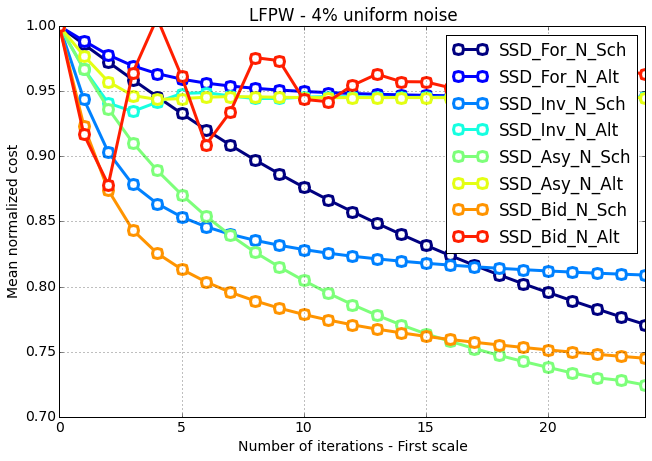

In [49]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)


for i in range(len(mean_costs)):
    plt.plot(np.arange(0, len(mean_costs[i])),
             mean_costs[i],
             color=colours[i],
             linewidth=3,
             marker='o',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=3)
    
plt.xlabel('Number of iterations - First scale')
plt.ylabel('Mean normalized cost')
plt.xlim((0, len(mean_costs[i]) - 1))
plt.ylim((0.7, 1))
plt.grid(True)
plt.legend(legend_entries[1:])

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(1.75 * fig.get_size_inches())

plt.savefig(result_name + 'mean_cost_vs_iters1_ssd_n_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

In [50]:
mean_costs = []
std_costs = []
median_costs = []
max_costs = np.zeros(len(fitters_results[0::n_fitters]))
for j in range(n_fitters):
    costs = []
    for k, fr in enumerate(fitters_results[j::n_fitters]):
        if max_costs[k] < fr.algorithm_results[1].costs[0]:
            max_costs[k] = fr.algorithm_results[1].costs[0]
        cost = list(fr.algorithm_results[1].costs)
        while len(cost) < np.sum(max_iters[1]) + 1:
            cost.append(cost[-1])
        costs.append(cost)
    costs = np.asarray(costs) / max_costs[..., None]
    mean_costs.append(np.mean(costs, axis=0))
    std_costs.append(np.std(costs, axis=0))
    median_costs.append(np.median(costs, axis=0))

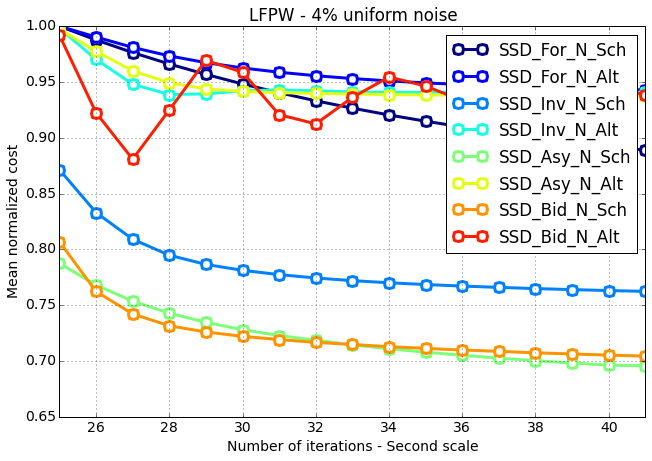

In [53]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)


for i in range(len(mean_costs)):
    plt.plot(np.arange(max_iters[0] + 1, np.sum(max_iters)+2),
             mean_costs[i],
             color=colours[i],
             linewidth=3,
             marker='o',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=3)
    
plt.xlabel('Number of iterations - Second scale')
plt.ylabel('Mean normalized cost')
plt.xlim((max_iters[0] + 1, np.sum(max_iters)+1))
plt.ylim((0.65, 1.0))
plt.grid(True)
plt.legend(legend_entries[1:])

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(1.75 * fig.get_size_inches())

plt.savefig(result_name + 'mean_cost_vs_iters2_ssd_n_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300,  bbox_inches='tight')

Time algorithms:

In [ ]:
%timeit fr = fitters[0].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[1].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[2].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[3].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[4].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[5].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 

For a particular algorithm: 

In [ ]:
visualize_fitting_result(fitters_results[2::n_fitters])

## Other

In [ ]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 